In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from definitions import ROOT_DIR
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(font_scale=1.2)
sns.set_style("dark")

- Inputs

In [2]:
p_root_dir = Path(ROOT_DIR).parents[0]
p_data = p_root_dir / "5_data_analysis"
p_out = p_root_dir / "6_plots/q2_plots/dot_plots"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / "all_predictions_curated_11-Dec-2021.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "datasets.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"
p_pathways = p_data / "pathways_v2.csv"

- Merge relevant info into one dataframe

In [3]:
def filter_neutral_losses(df, filter_on=True, neutral_losses_to_keep=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    '''
    if filter_on:
        df = df[df.neutral_loss.isin(neutral_losses_to_keep)]
    return df

def calculate_detected_intensities(df):
    '''
    Make a column with background corrected intensities for detected compounds, and 0s for not detected compounds
    Change any negative values to zero
    '''
    intensities_for_twostate_spots = (df.pred_twostate == 1) * df.spot_intensity_bgr_corrected
    df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
    intensities_for_threestate_spots = (df.pred_threestate == 2) * df.spot_intensity_bgr_corrected
    df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)
    return df

def filter_polarity(df, polarity):
    '''
    Filter out entries based on polarity pol ['pos', 'neg']
    '''
    return df[df['Polarity'] == polarity]

def group_by_molecule(df, intensity_col_name, prediction_col_name):
    '''
    Aggregate intensity and detection values per class
    '''
    
    if intensity_col_name == 'val_threestate':
        intensity_aggregation_func = lambda x: (x==2).any()
    else: intensity_aggregation_func = lambda x: (x==1).any()
            
    
    data = df.pivot_table(index=['name_short'],
                          columns=['sample_name'],
                          values=[intensity_col_name, prediction_col_name],
                          aggfunc = {
                                intensity_col_name : lambda x: np.log10(sum(x)+1),
                                prediction_col_name : intensity_aggregation_func
                          },
                          fill_value=0,
                          sort=False)
    data = data.stack(level=1, dropna=False).reset_index()
    return data

def prep_molecule_data(data, polarity,  intensity_col_name, prediction_col_name, nl_filter_on=False, neutral_losses_to_keep=None):
    '''
    '''
    data = filter_neutral_losses(data, nl_filter_on, neutral_losses_to_keep)
    data = calculate_detected_intensities(data)
    data = filter_polarity(data, polarity)
    data = group_by_molecule(data, intensity_col_name, prediction_col_name)
    
    return data

In [4]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)
predictions.neutral_loss.fillna('', inplace=True)

# TODO: remove thermometer ions

chem_class = pd.read_csv(p_chem_class, index_col='internal_id')
main_chem_class = chem_class[['name_short', 'main_coarse_class']].drop_duplicates()
pathways = pd.read_csv(p_pathways, index_col='internal_id')
main_pathways = pathways[['name_short', 'main_coarse_path']].drop_duplicates()

# Get a subset of most relevant information from Datasets file
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Clone ID').first()[['Polarity', 'Matrix short', 'Matrix long', 'Slide code']] # 'Participant lab', 'Technology'
datasets_info['sample_name'] = datasets_info['Matrix short']
# datasets_info['sample_name'] = datasets_info['Matrix short'] + '_' + datasets_info['Slide code']

# Merge with predictions and classification
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Clone ID', how='left')

### Part 1: Dot plot with main chemical classes or pathways

In [5]:
def summarise_per_coarse_class(df, class_col_name, intensity_col_name, prediction_col_name):
    
    df['class_size'] =1
    data = df.pivot_table(index=['sample_name'],
                                   columns=class_col_name,
                                   values=[intensity_col_name, prediction_col_name, 'class_size'],
                                   aggfunc = {
                                        'class_size':sum,
                                        prediction_col_name : sum,
                                        intensity_col_name : np.mean
                                   },
                                   fill_value=0,
                                   sort=False)
    
    data = data.stack(level=1, dropna=False).reset_index()
    data['fraction_detected'] = data[prediction_col_name] / data['class_size']
    
    
    # sort columns alphabetically
    data = data.sort_values(by='sample_name')    
    return data

def plot_coarse_dot_plot(plot_data, cmap, class_col_name, intensity_col_name, title=""):
    
    plt.figure(figsize=(12,4.5))
    g = sns.scatterplot(data=plot_data, 
                        x='sample_name', 
                        y=class_col_name, 
                        size="fraction_detected", sizes=(1,400),
                        hue=intensity_col_name, palette=cmap,
                        linewidth = 0
            )

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
#     plt.xticks(rotation=90)
    plt.tight_layout()

    return g

In [6]:
# Choose colourmap
cmap = sns.choose_colorbrewer_palette('s', as_cmap=True)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

<AxesSubplot:>

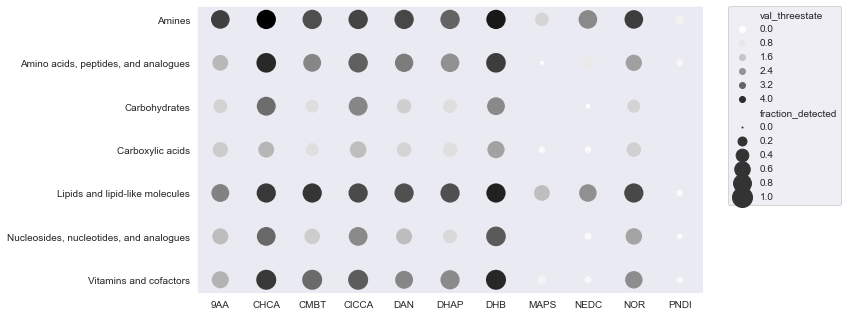

In [7]:
# Summarise data per molecule (intensities of its detected ions are summed)
molecule_data = prep_molecule_data(df,
                                   polarity='pos', 
                                   nl_filter_on=False, 
                                   neutral_losses_to_keep=[''], 
                                   intensity_col_name='val_threestate',
                                   prediction_col_name = 'pred_threestate')

# Map chemical classes
mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

# Summarise data per class
class_data = summarise_per_coarse_class(mapped_data,
                                        class_col_name='main_coarse_class',
                                        intensity_col_name ='val_threestate',
                                        prediction_col_name = 'pred_threestate')

plot_coarse_dot_plot(class_data, cmap, 
              class_col_name='main_coarse_class', 
              intensity_col_name = 'val_threestate')

- Batch-save many plots with changing filters:

1. With and without neutral losses
2. In both ionisation modes
3. With 50% (val_twostate) or 80% (val_threestate) ion detection confidence

In [9]:
for nl_filter_on in [True, False]:
    
    nl_label = 'with n.l.'
    if nl_filter_on: 
        nl_label = 'no n.l.'       
    
    for polarity in ['pos', 'neg']:
        
        for catboost in ['twostate', 'threestate']:

            # Summarise data per molecule (intensities of its detected ions are summed)
            molecule_data = prep_molecule_data(df,
                                               polarity=polarity, 
                                               nl_filter_on=nl_filter_on, 
                                               neutral_losses_to_keep=[''], 
                                               intensity_col_name=f'val_{catboost}',
                                               prediction_col_name = f'pred_{catboost}')

            # Map chemical classes
            for class_col_name in ['main_coarse_class', 'main_coarse_path']:
                
                if class_col_name == 'main_coarse_class':
                    mapped_data = molecule_data.merge(main_chem_class, on='name_short', how='left')
                elif class_col_name == 'main_coarse_path':
                    mapped_data = molecule_data.merge(main_pathways, on='name_short', how='left')                   

                    
            # Summarise data per class
                class_data = summarise_per_coarse_class(mapped_data,
                                                        class_col_name=class_col_name,
                                                        intensity_col_name =f'val_{catboost}',
                                                        prediction_col_name = f'pred_{catboost}')
            #Make the plot
                title = f"Fraction and avg.intensity {polarity} {catboost} {nl_label} {class_col_name}"
                g = plot_coarse_dot_plot(class_data, cmap, 
                                         class_col_name=class_col_name, 
                                         intensity_col_name = f'val_{catboost}',
                                         title=title)
            # Save the plot
                g.figure.savefig(p_out / f"{title}.png")
                plt.close()  

<ipython-input-3-c5d326bd7cec>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
<ipython-input-3-c5d326bd7cec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)
<ipython-input-3-c5d326bd7cec>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

# Part 2: Dot plot with fine chemical classes or pathways

In [10]:
def summarise_per_fine_class(df, fine_class_col_name, coarse_class_col_name, intensity_col_name, prediction_col_name):
    
    df['class_size'] =1
    data = df.pivot_table(index=['sample_name'],
                                   columns=[fine_class_col_name, coarse_class_col_name],
                                   values=[intensity_col_name, prediction_col_name, 'class_size'],
                                   aggfunc = {
                                        'class_size':sum,
                                        prediction_col_name : sum,
                                        intensity_col_name : np.mean
                                   },
                                   fill_value=0,
                                   sort=False)
    
    data = data.stack(level=[1,2], dropna=True).reset_index()
    data['fraction_detected'] = data[prediction_col_name] / data['class_size']    
    
    # sort columns alphabetically
    data = data.sort_values(by='sample_name')
    # sort rows first by coarse class, then by fine class
    data = data.sort_values(by=[coarse_class_col_name, fine_class_col_name])
    return data

def plot_fine_dot_plot(plot_data, cmap, class_col_name, intensity_col_name, title=""):
    
    plt.figure(figsize=(12,12))
    g = sns.scatterplot(data=plot_data, 
                        x='sample_name', 
                        y=class_col_name, 
                        size="fraction_detected", sizes=(1,400),
                        hue=intensity_col_name, palette=cmap,
                        linewidth = 0
            )

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
#     plt.xticks(rotation=90)
    plt.tight_layout()

    return g

In [11]:
# Choose colourmap
cmap = sns.choose_colorbrewer_palette('s', as_cmap=True)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

<ipython-input-3-c5d326bd7cec>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
<ipython-input-3-c5d326bd7cec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)


<AxesSubplot:title={'center':'Test'}>

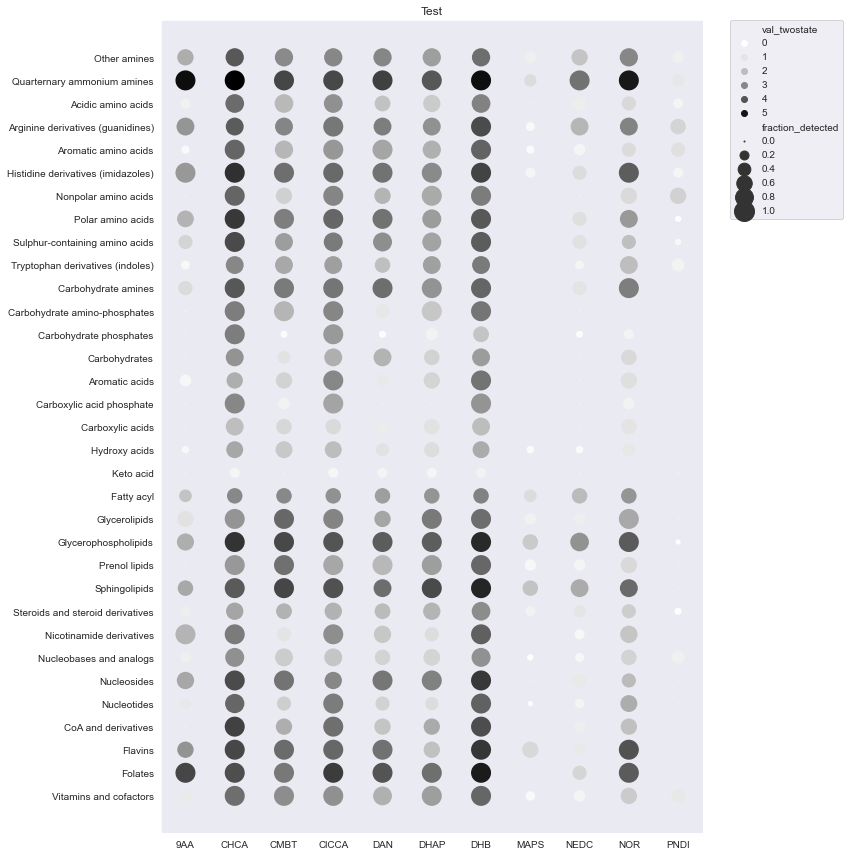

In [12]:
# Summarise data per molecule (intensities of its detected ions are summed)
molecule_data = prep_molecule_data(df,
                                   polarity='pos', 
                                   nl_filter_on=True, 
                                   neutral_losses_to_keep=[''], 
                                   intensity_col_name='val_twostate',
                                   prediction_col_name = 'pred_twostate')

# Map chemical classes
mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

# Summarise data per class
class_data = summarise_per_fine_class(mapped_data,
                                      fine_class_col_name='fine_class',
                                      coarse_class_col_name='coarse_class',
                                      intensity_col_name ='val_twostate',
                                      prediction_col_name = 'pred_twostate')

plot_fine_dot_plot(class_data, cmap, 
                   class_col_name='fine_class', 
                   intensity_col_name = 'val_twostate',
                   title="Test")

- Batch-save many plots with changing filters:

1. With and without neutral losses
2. In both ionisation modes
3. With 50% (val_twostate) or 80% (val_threestate) ion detection confidence

In [13]:
for nl_filter_on in [True, False]:
    
    nl_label = 'with n.l.'
    if nl_filter_on: 
        nl_label = 'no n.l.'       
    
    for polarity in ['pos', 'neg']:
        
        for catboost in ['twostate', 'threestate']:

            # Summarise data per molecule (intensities of its detected ions are summed)
            molecule_data = prep_molecule_data(df,
                                               polarity=polarity, 
                                               nl_filter_on=nl_filter_on, 
                                               neutral_losses_to_keep=[''], 
                                               intensity_col_name=f'val_{catboost}',
                                               prediction_col_name = f'pred_{catboost}')

            # Map chemical classes
            for fine_class_col_name, coarse_class_col_name in [('fine_class', 'coarse_class'), ('fine_path', 'coarse_path')]:
                
                if fine_class_col_name == 'fine_class':
                    mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')
                elif fine_class_col_name == 'fine_path':
                    mapped_data = molecule_data.merge(pathways, on='name_short', how='left')                   

                    
            # Summarise data per class
                class_data = summarise_per_fine_class(mapped_data,
                                                      fine_class_col_name=fine_class_col_name,
                                                      coarse_class_col_name=coarse_class_col_name,
                                                      intensity_col_name =f'val_{catboost}',
                                                      prediction_col_name = f'pred_{catboost}')
           
            # Make the plot     
                title = f"Fraction and mean log10 intensity {nl_label} {polarity} {catboost} {fine_class_col_name}"
                g = plot_fine_dot_plot(class_data, cmap, 
                                  class_col_name=fine_class_col_name, 
                                  intensity_col_name = f'val_{catboost}')
            # Save the plot
                g.figure.savefig(p_out / f"{title}.png")
                plt.close()  

<ipython-input-3-c5d326bd7cec>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
<ipython-input-3-c5d326bd7cec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)
<ipython-input-3-c5d326bd7cec>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the